In [2]:
%matplotlib inline


Reinforcement Learning (DQN) Tutorial
=====================================
**Author**: `Adam Paszke <https://github.com/apaszke>`_


This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN) agent
on the CartPole-v0 task from the `OpenAI Gym <https://gym.openai.com/>`__.

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find an
official leaderboard with various algorithms and visualizations at the
`Gym website <https://gym.openai.com/envs/CartPole-v0>`__.

.. figure:: /_static/img/cartpole.gif
   :alt: cartpole

   cartpole

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, rewards are +1 for every incremental timestep and the environment
terminates if the pole falls over too far or the cart moves more then 2.4
units away from center. This means better performing scenarios will run
for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.).
However, neural networks can solve the task purely by looking at the
scene, so we'll use a patch of the screen centered on the cart as an
input. Because of this, our results aren't directly comparable to the
ones from the official leaderboard - our task is much harder.
Unfortunately this does slow down the training, because we have to
render all the frames.

Strictly speaking, we will present the state as the difference between
the current screen patch and the previous one. This will allow the agent
to take the velocity of the pole into account from one image.

**Packages**


First, let's import needed packages. Firstly, we need
`gym <https://gym.openai.com/docs>`__ for the environment
(Install using `pip install gym`).
We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)
-  utilities for vision tasks (``torchvision`` - `a separate
   package <https://github.com/pytorch/vision>`__).




In [3]:
%%capture
!sudo apt update && sudo apt install python-opengl
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper stable-baselines[mpi] box2d box2d-kengz pyvirtualdisplay pyglet
!pip install gym
!pip install wandb
!pip install gym pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq
project="gym_car_racer"
entity="andreas_giannoutsos"
import wandb



In [4]:
!git clone https://github.com/openai/gym.git
%cd gym
!pip install -e .

fatal: destination path 'gym' already exists and is not an empty directory.
/content/gym
Obtaining file:///content/gym
  Found existing installation: gym 0.18.0
    Can't uninstall 'gym'. No files were found to uninstall.
  Running setup.py develop for gym


In [5]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import gnwrapper


env = gnwrapper.Animation(gym.make('CartPole-v1'))

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Replay Memory
-------------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
# memory

Now, let's define our model. But first, let quickly recap what a DQN is.

DQN algorithm
-------------

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

Q-network
^^^^^^^^^

Our model will be a convolutional neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *expected return* of
taking each action given the current input.




In [8]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

Input extraction
^^^^^^^^^^^^^^^^

The code below are utilities for extracting and processing rendered
images from the environment. It uses the ``torchvision`` package, which
makes it easy to compose image transforms. Once you run the cell it will
display an example patch that it extracted.




## CaR REWREC

In [9]:
import sys, math
import numpy as np

import Box2D
from Box2D.b2 import (edgeShape, circleShape, fixtureDef, polygonShape, revoluteJointDef, contactListener)

import gym
from gym import spaces
from gym.envs.box2d.car_dynamics import Car
from gym.utils import colorize, seeding, EzPickle

import pyglet
from pyglet import gl

# Easiest continuous control task to learn from pixels, a top-down racing environment.
# Discrete control is reasonable in this environment as well, on/off discretization is
# fine.
#
# State consists of STATE_W x STATE_H pixels.
#
# Reward is -0.1 every frame and +1000/N for every track tile visited, where N is
# the total number of tiles visited in the track. For example, if you have finished in 732 frames,
# your reward is 1000 - 0.1*732 = 926.8 points.
#
# Game is solved when agent consistently gets 900+ points. Track generated is random every episode.
#
# Episode finishes when all tiles are visited. Car also can go outside of PLAYFIELD, that
# is far off the track, then it will get -100 and die.
#
# Some indicators shown at the bottom of the window and the state RGB buffer. From
# left to right: true speed, four ABS sensors, steering wheel position and gyroscope.
#
# To play yourself (it's rather fast for humans), type:
#
# python gym/envs/box2d/car_racing.py
#
# Remember it's powerful rear-wheel drive car, don't press accelerator and turn at the
# same time.
#
# Created by Oleg Klimov. Licensed on the same terms as the rest of OpenAI Gym.

STATE_W = 96   # less than Atari 160x192
STATE_H = 96
VIDEO_W = 600
VIDEO_H = 400
WINDOW_W = 1000
WINDOW_H = 800

SCALE       = 6.0        # Track scale
TRACK_RAD   = 900/SCALE  # Track is heavily morphed circle with this radius
PLAYFIELD   = 2000/SCALE # Game over boundary
FPS         = 50         # Frames per second
ZOOM        = 2.7        # Camera zoom
ZOOM_FOLLOW = True       # Set to False for fixed view (don't use zoom)


TRACK_DETAIL_STEP = 21/SCALE
TRACK_TURN_RATE = 0.31
TRACK_WIDTH = 40/SCALE
BORDER = 8/SCALE
BORDER_MIN_COUNT = 4

ROAD_COLOR = [0.4, 0.4, 0.4]

class FrictionDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env
    def BeginContact(self, contact):
        self._contact(contact, True)
    def EndContact(self, contact):
        self._contact(contact, False)
    def _contact(self, contact, begin):
        tile = None
        obj = None
        u1 = contact.fixtureA.body.userData
        u2 = contact.fixtureB.body.userData
        if u1 and "road_friction" in u1.__dict__:
            tile = u1
            obj  = u2
        if u2 and "road_friction" in u2.__dict__:
            tile = u2
            obj  = u1
        if not tile:
            return

        tile.color[0] = ROAD_COLOR[0]
        tile.color[1] = ROAD_COLOR[1]
        tile.color[2] = ROAD_COLOR[2]
        if not obj or "tiles" not in obj.__dict__:
            return
        if begin:
            obj.tiles.add(tile)
            # print tile.road_friction, "ADD", len(obj.tiles)
            if not tile.road_visited:
                tile.road_visited = True
                self.env.reward += 1000.0/len(self.env.track)
                self.env.tile_visited_count += 1
        else:
            obj.tiles.remove(tile)
            # print tile.road_friction, "DEL", len(obj.tiles) -- should delete to zero when on grass (this works)

class CarRacing(gym.Env, EzPickle):
    metadata = {
        'render.modes': ['human', 'rgb_array', 'state_pixels'],
        'video.frames_per_second' : FPS
    }

    def __init__(self, verbose=1):
        EzPickle.__init__(self)
        self.seed()
        self.contactListener_keepref = FrictionDetector(self)
        self.world = Box2D.b2World((0,0), contactListener=self.contactListener_keepref)
        self.viewer = None
        self.invisible_state_window = None
        self.invisible_video_window = None
        self.road = None
        self.car = None
        self.reward = 0.0
        self.prev_reward = 0.0
        self.verbose = verbose
        self.fd_tile = fixtureDef(
                shape = polygonShape(vertices=
                    [(0, 0),(1, 0),(1, -1),(0, -1)]))

        self.action_space = spaces.Box( np.array([-1,0,0]), np.array([+1,+1,+1]), dtype=np.float32)  # steer, gas, brake
        self.actions = [np.array([-1,0,0], dtype=np.float32), 
                        np.array([1,0,0], dtype=np.float32), 
                        np.array([0,1,0], dtype=np.float32), 
                        np.array([0,0,0.8], dtype=np.float32), 
                        np.array([0,0,0], dtype=np.float32)]  # left right, gas, brake, nothing

        self.observation_space = spaces.Box(low=0, high=255, shape=(STATE_H, STATE_W, 3), dtype=np.uint8)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _destroy(self):
        if not self.road:
            return
        for t in self.road:
            self.world.DestroyBody(t)
        self.road = []
        self.car.destroy()

    def _create_track(self):
        CHECKPOINTS = 12

        # Create checkpoints
        checkpoints = []
        for c in range(CHECKPOINTS):
            alpha = 2*math.pi*c/CHECKPOINTS + self.np_random.uniform(0, 2*math.pi*1/CHECKPOINTS)
            rad = self.np_random.uniform(TRACK_RAD/3, TRACK_RAD)
            if c==0:
                alpha = 0
                rad = 1.5*TRACK_RAD
            if c==CHECKPOINTS-1:
                alpha = 2*math.pi*c/CHECKPOINTS
                self.start_alpha = 2*math.pi*(-0.5)/CHECKPOINTS
                rad = 1.5*TRACK_RAD
            checkpoints.append( (alpha, rad*math.cos(alpha), rad*math.sin(alpha)) )

        # print "\n".join(str(h) for h in checkpoints)
        # self.road_poly = [ (    # uncomment this to see checkpoints
        #    [ (tx,ty) for a,tx,ty in checkpoints ],
        #    (0.7,0.7,0.9) ) ]
        self.road = []

        # Go from one checkpoint to another to create track
        x, y, beta = 1.5*TRACK_RAD, 0, 0
        dest_i = 0
        laps = 0
        track = []
        no_freeze = 2500
        visited_other_side = False
        while True:
            alpha = math.atan2(y, x)
            if visited_other_side and alpha > 0:
                laps += 1
                visited_other_side = False
            if alpha < 0:
                visited_other_side = True
                alpha += 2*math.pi
            while True: # Find destination from checkpoints
                failed = True
                while True:
                    dest_alpha, dest_x, dest_y = checkpoints[dest_i % len(checkpoints)]
                    if alpha <= dest_alpha:
                        failed = False
                        break
                    dest_i += 1
                    if dest_i % len(checkpoints) == 0:
                        break
                if not failed:
                    break
                alpha -= 2*math.pi
                continue
            r1x = math.cos(beta)
            r1y = math.sin(beta)
            p1x = -r1y
            p1y = r1x
            dest_dx = dest_x - x  # vector towards destination
            dest_dy = dest_y - y
            proj = r1x*dest_dx + r1y*dest_dy  # destination vector projected on rad
            while beta - alpha >  1.5*math.pi:
                 beta -= 2*math.pi
            while beta - alpha < -1.5*math.pi:
                 beta += 2*math.pi
            prev_beta = beta
            proj *= SCALE
            if proj >  0.3:
                 beta -= min(TRACK_TURN_RATE, abs(0.001*proj))
            if proj < -0.3:
                 beta += min(TRACK_TURN_RATE, abs(0.001*proj))
            x += p1x*TRACK_DETAIL_STEP
            y += p1y*TRACK_DETAIL_STEP
            track.append( (alpha,prev_beta*0.5 + beta*0.5,x,y) )
            if laps > 4:
                 break
            no_freeze -= 1
            if no_freeze==0:
                 break
        # print "\n".join([str(t) for t in enumerate(track)])

        # Find closed loop range i1..i2, first loop should be ignored, second is OK
        i1, i2 = -1, -1
        i = len(track)
        while True:
            i -= 1
            if i==0:
                return False  # Failed
            pass_through_start = track[i][0] > self.start_alpha and track[i-1][0] <= self.start_alpha
            if pass_through_start and i2==-1:
                i2 = i
            elif pass_through_start and i1==-1:
                i1 = i
                break
        if self.verbose == 1:
            print("Track generation: %i..%i -> %i-tiles track" % (i1, i2, i2-i1))
        assert i1!=-1
        assert i2!=-1

        track = track[i1:i2-1]

        first_beta = track[0][1]
        first_perp_x = math.cos(first_beta)
        first_perp_y = math.sin(first_beta)
        # Length of perpendicular jump to put together head and tail
        well_glued_together = np.sqrt(
            np.square( first_perp_x*(track[0][2] - track[-1][2]) ) +
            np.square( first_perp_y*(track[0][3] - track[-1][3]) ))
        if well_glued_together > TRACK_DETAIL_STEP:
            return False

        # Red-white border on hard turns
        border = [False]*len(track)
        for i in range(len(track)):
            good = True
            oneside = 0
            for neg in range(BORDER_MIN_COUNT):
                beta1 = track[i-neg-0][1]
                beta2 = track[i-neg-1][1]
                good &= abs(beta1 - beta2) > TRACK_TURN_RATE*0.2
                oneside += np.sign(beta1 - beta2)
            good &= abs(oneside) == BORDER_MIN_COUNT
            border[i] = good
        for i in range(len(track)):
            for neg in range(BORDER_MIN_COUNT):
                border[i-neg] |= border[i]

        # Create tiles
        for i in range(len(track)):
            alpha1, beta1, x1, y1 = track[i]
            alpha2, beta2, x2, y2 = track[i-1]
            road1_l = (x1 - TRACK_WIDTH*math.cos(beta1), y1 - TRACK_WIDTH*math.sin(beta1))
            road1_r = (x1 + TRACK_WIDTH*math.cos(beta1), y1 + TRACK_WIDTH*math.sin(beta1))
            road2_l = (x2 - TRACK_WIDTH*math.cos(beta2), y2 - TRACK_WIDTH*math.sin(beta2))
            road2_r = (x2 + TRACK_WIDTH*math.cos(beta2), y2 + TRACK_WIDTH*math.sin(beta2))
            vertices = [road1_l, road1_r, road2_r, road2_l]
            self.fd_tile.shape.vertices = vertices
            t = self.world.CreateStaticBody(fixtures=self.fd_tile)
            t.userData = t
            c = 0.01*(i%3)
            t.color = [ROAD_COLOR[0] + c, ROAD_COLOR[1] + c, ROAD_COLOR[2] + c]
            t.road_visited = False
            t.road_friction = 1.0
            t.fixtures[0].sensor = True
            self.road_poly.append(( [road1_l, road1_r, road2_r, road2_l], t.color ))
            self.road.append(t)
            if border[i]:
                side = np.sign(beta2 - beta1)
                b1_l = (x1 + side* TRACK_WIDTH        *math.cos(beta1), y1 + side* TRACK_WIDTH        *math.sin(beta1))
                b1_r = (x1 + side*(TRACK_WIDTH+BORDER)*math.cos(beta1), y1 + side*(TRACK_WIDTH+BORDER)*math.sin(beta1))
                b2_l = (x2 + side* TRACK_WIDTH        *math.cos(beta2), y2 + side* TRACK_WIDTH        *math.sin(beta2))
                b2_r = (x2 + side*(TRACK_WIDTH+BORDER)*math.cos(beta2), y2 + side*(TRACK_WIDTH+BORDER)*math.sin(beta2))
                self.road_poly.append(( [b1_l, b1_r, b2_r, b2_l], (1,1,1) if i%2==0 else (1,0,0) ))
        self.track = track
        return True

    def reset(self):
        self._destroy()
        self.reward = 0.0
        self.prev_reward = 0.0
        self.tile_visited_count = 0
        self.t = 0.0
        self.road_poly = []

        while True:
            success = self._create_track()
            if success:
                break
            if self.verbose == 1:
                print("retry to generate track (normal if there are not many of this messages)")
        self.car = Car(self.world, *self.track[0][1:4])

        return self.step(None)[0]

    def step(self, action):
        if action is not None:
            self.car.steer(-action[0])
            self.car.gas(action[1])
            self.car.brake(action[2])

        self.car.step(1.0/FPS)
        self.world.Step(1.0/FPS, 6*30, 2*30)
        self.t += 1.0/FPS

        self.state = self.render("state_pixels")

        step_reward = 0
        done = False
        if action is not None: # First step without action, called from reset()
            self.reward -= 0.1
            # We actually don't want to count fuel spent, we want car to be faster.
            # self.reward -=  10 * self.car.fuel_spent / ENGINE_POWER
            self.car.fuel_spent = 0.0
            step_reward = self.reward - self.prev_reward
            self.prev_reward = self.reward
            if self.tile_visited_count==len(self.track):
                done = True
            x, y = self.car.hull.position
            if abs(x) > PLAYFIELD or abs(y) > PLAYFIELD:
                done = True
                step_reward = -100

        return self.state, step_reward, done, {}

    def render(self, mode='human'):
        assert mode in ['human', 'state_pixels', 'rgb_array']
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(WINDOW_W, WINDOW_H)
            self.score_label = pyglet.text.Label('0000', font_size=36,
                x=20, y=WINDOW_H*2.5/40.00, anchor_x='left', anchor_y='center',
                color=(255,255,255,255))
            self.transform = rendering.Transform()

        if "t" not in self.__dict__: return  # reset() not called yet

        zoom = 0.1*SCALE*max(1-self.t, 0) + ZOOM*SCALE*min(self.t, 1)   # Animate zoom first second
        zoom = 0.1*SCALE*0 + ZOOM*SCALE*1   # Animate zoom first second
        zoom_state  = ZOOM*SCALE*STATE_W/WINDOW_W
        zoom_video  = ZOOM*SCALE*VIDEO_W/WINDOW_W
        scroll_x = self.car.hull.position[0]
        scroll_y = self.car.hull.position[1]
        angle = -self.car.hull.angle
        vel = self.car.hull.linearVelocity
        if np.linalg.norm(vel) > 0.5:
            angle = math.atan2(vel[0], vel[1])
        self.transform.set_scale(zoom, zoom)
        self.transform.set_translation(
            WINDOW_W/2 - (scroll_x*zoom*math.cos(angle) - scroll_y*zoom*math.sin(angle)),
            WINDOW_H/4 - (scroll_x*zoom*math.sin(angle) + scroll_y*zoom*math.cos(angle)) )
        self.transform.set_rotation(angle)

        self.car.draw(self.viewer, mode!="state_pixels")

        arr = None
        win = self.viewer.window
        win.switch_to()
        win.dispatch_events()

        win.clear()
        t = self.transform
        if mode=='rgb_array':
            VP_W = VIDEO_W
            VP_H = VIDEO_H
        elif mode == 'state_pixels':
            VP_W = STATE_W
            VP_H = STATE_H
        else:
            pixel_scale = 1
            if hasattr(win.context, '_nscontext'):
                pixel_scale = win.context._nscontext.view().backingScaleFactor()  # pylint: disable=protected-access
            VP_W = int(pixel_scale * WINDOW_W)
            VP_H = int(pixel_scale * WINDOW_H)

        gl.glViewport(0, 0, VP_W, VP_H)
        t.enable()
        self.render_road()
        for geom in self.viewer.onetime_geoms:
            geom.render()
        self.viewer.onetime_geoms = []
        t.disable()
        self.render_indicators(WINDOW_W, WINDOW_H)

        if mode == 'human':
            win.flip()
            return self.viewer.isopen

        image_data = pyglet.image.get_buffer_manager().get_color_buffer().get_image_data()
        arr = np.fromstring(image_data.get_data(), dtype=np.uint8, sep='')
        arr = arr.reshape(VP_H, VP_W, 4)
        arr = arr[::-1, :, 0:3]

        return arr

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

    def render_road(self):
        gl.glBegin(gl.GL_QUADS)
        gl.glColor4f(0.4, 0.8, 0.4, 1.0)
        gl.glVertex3f(-PLAYFIELD, +PLAYFIELD, 0)
        gl.glVertex3f(+PLAYFIELD, +PLAYFIELD, 0)
        gl.glVertex3f(+PLAYFIELD, -PLAYFIELD, 0)
        gl.glVertex3f(-PLAYFIELD, -PLAYFIELD, 0)
        gl.glColor4f(0.4, 0.9, 0.4, 1.0)
        k = PLAYFIELD/20.0
        for x in range(-20, 20, 2):
            for y in range(-20, 20, 2):
                gl.glVertex3f(k*x + k, k*y + 0, 0)
                gl.glVertex3f(k*x + 0, k*y + 0, 0)
                gl.glVertex3f(k*x + 0, k*y + k, 0)
                gl.glVertex3f(k*x + k, k*y + k, 0)
        for poly, color in self.road_poly:
            gl.glColor4f(color[0], color[1], color[2], 1)
            for p in poly:
                gl.glVertex3f(p[0], p[1], 0)
        gl.glEnd()

    def render_indicators(self, W, H):
        gl.glBegin(gl.GL_QUADS)
        s = W/40.0
        h = H/40.0
        gl.glColor4f(0,0,0,1)
        gl.glVertex3f(W, 0, 0)
        gl.glVertex3f(W, 5*h, 0)
        gl.glVertex3f(0, 5*h, 0)
        gl.glVertex3f(0, 0, 0)
        def vertical_ind(place, val, color):
            gl.glColor4f(color[0], color[1], color[2], 1)
            gl.glVertex3f((place+0)*s, h + h*val, 0)
            gl.glVertex3f((place+1)*s, h + h*val, 0)
            gl.glVertex3f((place+1)*s, h, 0)
            gl.glVertex3f((place+0)*s, h, 0)
        def horiz_ind(place, val, color):
            gl.glColor4f(color[0], color[1], color[2], 1)
            gl.glVertex3f((place+0)*s, 4*h , 0)
            gl.glVertex3f((place+val)*s, 4*h, 0)
            gl.glVertex3f((place+val)*s, 2*h, 0)
            gl.glVertex3f((place+0)*s, 2*h, 0)
        true_speed = np.sqrt(np.square(self.car.hull.linearVelocity[0]) + np.square(self.car.hull.linearVelocity[1]))
        vertical_ind(5, 0.02*true_speed, (1,1,1))
        vertical_ind(7, 0.01*self.car.wheels[0].omega, (0.0,0,1)) # ABS sensors
        vertical_ind(8, 0.01*self.car.wheels[1].omega, (0.0,0,1))
        vertical_ind(9, 0.01*self.car.wheels[2].omega, (0.2,0,1))
        vertical_ind(10,0.01*self.car.wheels[3].omega, (0.2,0,1))
        horiz_ind(20, -10.0*self.car.wheels[0].joint.angle, (0,1,0))
        horiz_ind(30, -0.8*self.car.hull.angularVelocity, (1,0,0))
        gl.glEnd()
        self.score_label.text = "%04i" % self.reward
        self.score_label.draw()

## TEST CAR

/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1160..1454 -> 294-tiles track


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:413: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


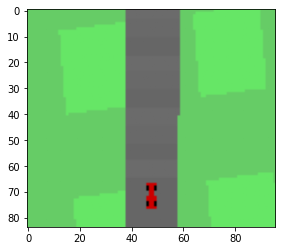

In [10]:
# from gym.envs.box2d import CarRacing
env = gnwrapper.Animation(CarRacing())
env = CarRacing()

env.reset()
env.render()
im = env.render("state_pixels")

def state_image_preprocess(state_image):
    # crop image
    state_image = state_image[0:84, :, :]
    state_image = state_image.transpose((2,0,1))
    # to torch
    state_image = np.ascontiguousarray(state_image, dtype=np.float32) / 255
    state_image = torch.from_numpy(state_image)
    return state_image.unsqueeze(0).to(device)

# plt.imshow(im)
state_image_preprocess(im).shape
plt.imshow(state_image_preprocess(im).cpu().squeeze(0).permute(1, 2, 0).numpy())

Track generation: 1170..1465 -> 295-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1227..1538 -> 311-tiles track


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:413: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


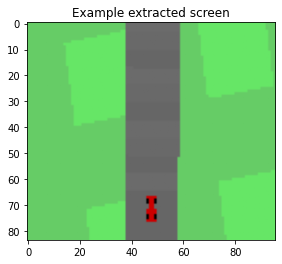

In [11]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

# def get_screen():
#     # Returned screen requested by gym is 400x600x3, but is sometimes larger
#     # such as 800x1200x3. Transpose it into torch order (CHW).
#     state_image = env.render(mode='rgb_array').transpose((2, 0, 1))
#     state_image = state_image[0:84, :, :]
#     state_image = state_image.transpose((2,0,1))
#     # to torch
#     state_image = np.ascontiguousarray(state_image, dtype=np.float32) / 255
#     state_image = torch.from_numpy(state_image)
#     return resize(state_image).unsqueeze(0).to(device)
#     # Cart is in the lower half, so strip off the top and bottom of the screen
#     _, screen_height, screen_width = screen.shape
#     screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
#     view_width = int(screen_width * 0.6)
#     cart_location = get_cart_location(screen_width)
#     if cart_location < view_width // 2:
#         slice_range = slice(view_width)
#     elif cart_location > (screen_width - view_width // 2):
#         slice_range = slice(-view_width, None)
#     else:
#         slice_range = slice(cart_location - view_width // 2,
#                             cart_location + view_width // 2)
#     # Strip off the edges, so that we have a square image centered on a cart
#     screen = screen[:, :, slice_range]
#     # Convert to float, rescale, convert to torch tensor
#     # (this doesn't require a copy)
#     screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
#     screen = torch.from_numpy(screen)
#     # Resize, and add a batch dimension (BCHW)
#     return resize(screen).unsqueeze(0).to(device)


def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    state_image = env.render(mode='state_pixels')
    state_image = state_image[0:84, :, :]
    state_image = state_image.transpose((2,0,1))
    # to torch
    state_image = np.ascontiguousarray(state_image, dtype=np.float32) / 255
    state_image = torch.from_numpy(state_image)
    return state_image.unsqueeze(0).to(device)


    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy())
plt.title('Example extracted screen')
plt.show()

Training
--------

Hyperparameters and utilities
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [12]:
env.actions

[array([-1.,  0.,  0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0. , 0. , 0.8], dtype=float32),
 array([0., 0., 0.], dtype=float32)]

In [13]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
# n_actions = env.action_space.n
n_actions = len(env.actions)

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:413: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [14]:
memory.position

0

Training loop
^^^^^^^^^^^^^

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




In [15]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    debug=False
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    if debug:
        print("action_batch", action_batch.size())
        print("reward_batch", reward_batch.size())
        print("state_batch", state_batch.size())
        print("state_action_values", state_action_values.size())
        print("non_final_next_states", non_final_next_states.size())
        print("expected_state_action_values", expected_state_action_values.size())

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [16]:
optimize_model()

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes, such as 300+ for meaningful
duration improvements.




In [17]:

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)

import numpy as np
import random
import math
import glob
import io
import os
import cv2
import base64
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque
from datetime import datetime

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
# import wandb
import wandb
import time

# record gameplay video
# display = Display(visible=0, size=(1400, 900))
# display.start()

DEBUG               = False
NUM_OF_EPISODES     = 5
NUM_OF_STEPS        = 100
LOG_VIDEO_EPISODES  = 2
WANDB_ID            = "sexyid123_new2"
WNDB_NAME           = "Test_bruuuu_new_new2"
LOAD_SAVED_MODEL    = False
MODEL_SAVE_NAME     = "DQN_test_model"
OPTIMIZER_SAVE_NAME = "DQN_test_optimizer"
SAVED_MODEL_VERSION = "latest"


# wnadb api key
# 00d5bfbd342bb73d5aaf4f2833436d20457ef040
os.environ["WANDB_ENTITY"]  = "andreas_giannoutsos"
os.environ["WANDB_PROJECT"] = "gym_car_racer"
os.environ["WANDB_RESUME"]  = "allow"
wandb.init(resume=WANDB_ID)
wandb.run.name = WNDB_NAME

# load model
if LOAD_SAVED_MODEL:
    try:
        model_artifact = wandb.use_artifact(MODEL_SAVE_NAME+':'+SAVED_MODEL_VERSION, type='model')
        artifact_dir = model_artifact.download()
        saved_model = torch.load(artifact_dir+"/"+MODEL_SAVE_NAME+".pth")
        saved_optimizer = torch.load(artifact_dir+"/"+OPTIMIZER_SAVE_NAME+".pth")
    except:
        print("no model found")

env = CarRacing()

for i_episode in range(NUM_OF_EPISODES):

    # Initialize the environment and state    
    if (i_episode % LOG_VIDEO_EPISODES == 0):
        env = gym.wrappers.Monitor(CarRacing(), './video', force=True)
    else:
        env = CarRacing()
        
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in range(NUM_OF_STEPS):

        ################# Select and perform an action ##################
        fw_start = time.time() 
        action = select_action(state)
        fw_end = time.time() 
        #################################################################


        ########################## render step ##########################
        render_start = time.time() 
        _, reward, done, _ = env.step(env.actions[action.item()])
        render_end = time.time()
        #################################################################


        ####################### Observe new state #######################
        reward = torch.tensor([reward], device=device)
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        next_state_time = time.time() 
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        # Move to the next state
        state = next_state
        #################################################################


        #################################################################
        # Perform one step of the optimization (on the target network) ##
        optimize_model()
        optimize_time = time.time() 
        #################################################################

        if DEBUG:
            print("step ", t)
            print("fw time ",fw_end- fw_start)
            print("render time ", render_end-render_start)
            print("next state time ", next_state_time- render_end)
            print("otpimize_time ", optimize_time- next_state_time)
        if done:
            episode_durations.append(t + 1)
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    env.close() 

    # render gameplay video and save model checkpoint
    if (i_episode % LOG_VIDEO_EPISODES == 0):
        
        # Save your model and optimizer
        torch.save(policy_net.state_dict(), MODEL_SAVE_NAME+".pth")
        torch.save(optimizer.state_dict(), OPTIMIZER_SAVE_NAME+".pth")
        # Save as artifact for version control.
        artifact = wandb.Artifact(MODEL_SAVE_NAME, type='model')
        artifact.add_file(MODEL_SAVE_NAME+".pth")
        artifact.add_file(OPTIMIZER_SAVE_NAME+".pth")
        wandb.log_artifact(artifact)
        # run.join()


        mp4list = glob.glob('video/*.mp4')
        print(mp4list)
        if len(mp4list) > 0:
            print(len(mp4list))
            mp4 = mp4list[-1]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)

            # log gameplay video in wandb
            wandb.log({"gameplays": wandb.Video(mp4, fps=4, format="gif")})

            # display gameplay video
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(HTML(data='''<video alt="" autoplay 
                        loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
            print("Episode ",i_episode)

print('Complete')
# env.render()
# env.close()
# plt.ioff()
# plt.show()

Episode  4
Complete


In [23]:
wandb.init(resume=WANDB_ID)
wandb.run.name = WNDB_NAME

# load model
model_artifact = wandb.use_artifact(MODEL_SAVE_NAME+':latest', type='model')
artifact_dir = model_artifact.download()
saved_model = torch.load(artifact_dir+"/"+MODEL_SAVE_NAME+".pth")
saved_optimizer = torch.load(artifact_dir+"/"+OPTIMIZER_SAVE_NAME+".pth")

_runtime,22077
_timestamp,1613778608
_step,73


In [22]:
artifact_dir
saved_model = torch.load(artifact_dir+"/"+MODEL_SAVE_NAME+".pth")
saved_optimizer = torch.load(artifact_dir+"/"+OPTIMIZER_SAVE_NAME+".pth")


'./artifacts/DQN_test_model:v0'

In [ ]:
# env = gnwrapper.Animation(gym.make('CartPole-v1'))
env = gym.make('CartPole-v1')

obs = env.reset()

# for _ in range(100):
#     print(_)
#     action = select_action(get_screen())
#     next_obs, reward, done, info = env.step(action)
#     env.render()

#     obs = next_obs
#     if done:
#         obs = env.reset()
#         print(_)
total_steps = 0
num_episodes = 10
for i_episode in range(num_episodes):
    # Initialize the environment and state
    # env = gnwrapper.Animation(gym.make('CartPole-v1'))
    env = gym.make('CartPole-v1')

    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    print(i_episode)
    for t in count():
        total_steps+=1
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            break

env.close()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()
print("total steps ", total_steps)

Here is the diagram that illustrates the overall resulting data flow.

.. figure:: /_static/img/reinforcement_learning_diagram.jpg

Actions are chosen either randomly or based on a policy, getting the next
step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training of the
new policy. "Older" target_net is also used in optimization to compute the
expected Q values; it is updated occasionally to keep it current.


